In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn as sns
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

import scrublet as scr
import harmonypy as hm
import pickle
from random import sample
from matplotlib_venn import venn2
import scipy

### Load scData

In [2]:
#SG_DF = pd.read_pickle('./DAP3_SGRNA_IND_072821.pkl')

In [3]:
#CM_Cells = sc.read_h5ad('./DAP3_SC_CM_Pseudo_PHATE_Man_080521.h5ad')
#CM_Ordered_Cells = CM_Cells[CM_Cells.obs['rank_pseudotime'].sort_values()]

### Load RNA Seq Data

In [5]:
#file_dir = './GSE76525'

In [6]:
### Create sample name dictionary
sample_keys = pd.read_csv(file_dir + 'samples.txt', delimiter='\t', index_col=0).index
sample_values = pd.read_csv(file_dir + 'samples.txt', delimiter='\t', index_col=0)['condition'].tolist()
sample_values[2] = 'D01'

Sample_Dict = dict(zip(sample_keys,sample_values))

### RNA-Seq RPKM Normalize

In [7]:
Read_List = []
Timepoint_List = []
for key in Sample_Dict.keys():
    s_reads = pd.read_csv(file_dir + key + '_feature_counts.txt', delimiter='\t', header=1, index_col=0, usecols=[0,5,6]).iloc[:,1].values.tolist()
    if sum(s_reads) == 0:
        continue
    rpm_factor = sum(s_reads)/1000000
    rpm_reads = [read/rpm_factor for read in s_reads]
    Read_List.append(rpm_reads)
    Timepoint_List.append(Sample_Dict[key])

In [8]:
### Load just one for values
Initial_DF = pd.read_csv(file_dir + key + '_feature_counts.txt', delimiter='\t', header=1, index_col=0, usecols=[0,5,6])

In [9]:
RPM_DF = pd.DataFrame(data = Read_List, index=Timepoint_List, columns=pd.read_csv(file_dir + 'SRR3084936_feature_counts.txt', delimiter='\t', header=1, index_col=0, usecols=[0,5,6]).index).T

In [10]:
RPKM_DF = RPM_DF.iloc[:,0:].div(Initial_DF['Length'], axis=0)

In [11]:
### Average replicates
RPKM_DF = RPKM_DF.groupby(RPKM_DF.columns, axis=1).mean()

### When are our target genes most highly expressed?

In [13]:
## Unique list
Target_List = []
for target in SG_DF.columns:
    Target_List.append(target.split(':')[0])
Unique_Target_List = np.unique(Target_List)

In [14]:
# Dictionary to get individual sg name
Target_Name = []
Target_Guides = []

for target in Unique_Target_List:
    Target_Name.append(target)
    if Target_List.count(target) == 1:
        Target_Guides.append(target)
    else:
        Target_Guide_Range = list(range(Target_List.count(target)))
        
        Subset_Guides = []
        for guide in Target_Guide_Range:
            Subset_Guides.append(target + ':' + str(guide + 1))
        Target_Guides.append(Subset_Guides)
Guide_Dictionary = dict(zip(Target_Name,Target_Guides))

In [15]:
Promoters = []
for target in Guide_Dictionary.keys():
    try:
        if target.split('_')[1].startswith('PROM'):
            Promoters.append(target.split('_')[0])
    except:
        continue
Uni_Prom = np.unique(Promoters)

In [16]:
Target_List = []
Target_TP = []
for target in Uni_Prom:
    Target_List.append(target)
    Target_TP.append(RPKM_DF.columns[np.argwhere(np.asarray(RPKM_DF.loc[target]) == RPKM_DF.loc[target].max())[0][0]])
TP_Gene_DF = pd.DataFrame(data = Target_TP, index=Target_List)

### Target Gene Expression Through Pseudotime

In [25]:
## Unique list
Target_List = []
for target in SG_DF.columns:
    Target_List.append(target.split(':')[0])
Unique_Target_List = np.unique(Target_List)

In [26]:
# Dictionary to get individual sg name
Target_Name = []
Target_Guides = []

for target in Unique_Target_List:
    Target_Name.append(target)
    if Target_List.count(target) == 1:
        Target_Guides.append(target)
    else:
        Target_Guide_Range = list(range(Target_List.count(target)))
        
        Subset_Guides = []
        for guide in Target_Guide_Range:
            Subset_Guides.append(target + ':' + str(guide + 1))
        Target_Guides.append(Subset_Guides)
Guide_Dictionary = dict(zip(Target_Name,Target_Guides))

In [27]:
Promoters = []
for target in Guide_Dictionary.keys():
    try:
        if target.split('_')[1].startswith('PROM'):
            Promoters.append(target.split('_')[0])
    except:
        continue
Uni_Prom = np.unique(Promoters).tolist()

In [28]:
Target_List = []
Target_TP = []
for target in Uni_Prom:
    Target_List.append(target)
    Target_TP.append(RPKM_DF.loc[target].tolist())
TP_Gene_DF = pd.DataFrame(data = Target_TP, index=Target_List, columns=RPKM_DF.columns)

In [29]:
#FC_Gene_DF_Temp = TP_Gene_DF.sub(TP_Gene_DF['D00'],axis=0)
FC_Gene_DF = TP_Gene_DF.div(TP_Gene_DF['D00'],axis=0)

In [30]:
Ordered_Genes = []
End_Genes = []
for gene in FC_Gene_DF.sort_values(by='D01', ascending=False).index:
    if sum(FC_Gene_DF.loc[gene] > 1) > 0:
        Ordered_Genes.append(gene)
    else:
        End_Genes.append(gene)

In [31]:
Ordered_Genes = Ordered_Genes + End_Genes

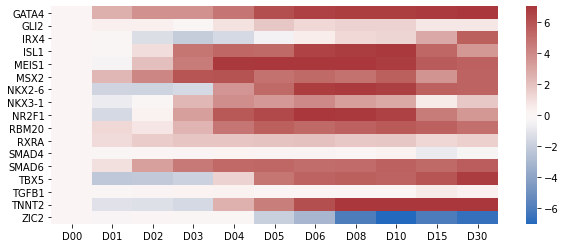

In [39]:
fig, ax = plt.subplots(1, figsize=(10,4))
h = sns.heatmap(np.log2(FC_Gene_DF.sort_index()),cmap="vlag", vmin=-7,center=0,vmax=7)
plt.savefig('./BULK_RNA_Targeted_Genes.pdf')